This model is the first model. It is called text sequence address classification.  
Aim: To teach the model to learn if a string contains any address information or not.  
Example of the test is at block 18.  

In [1]:
!pip install transformers
!pip install --upgrade tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 45.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import requests
from tensorflow.python.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay, precision_score, roc_auc_score
from sklearn import metrics
import seaborn as sns
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load cleaned dataset

read_data function is to read the dataset. In this model we select amount of dataset that we want due to resource limitation (memory allocation on kaggle notebook)

remove_empty_row 

In [3]:
def read_data(file_path):
    ori_data = pd.read_csv(file_path) #dtype='string'
#     data = ori_data.loc[514400:515400] 
#      data = ori_data.loc[502901:527900]
#     data = ori_data.loc[510400:520400]

    data_range1 = ori_data.loc[0:1999]
    data_range2 = ori_data.loc[515400:517399]
    data = pd.concat([data_range1, data_range2], ignore_index=True)
    print(data.head())
    print(len(data))
    
    return data
#to remove empty row
def remove_empty_row(data):
    data = data.dropna(subset=['Entity', 'Address'], how='all')
    return data

#to check if an address exist or not. used as true labels for model to learn later
def check_address_exist(labels):
    if labels:
        return 0
    else:
        return 1
    
import random

#combine address and entity column to make a string
#various combination as we want the model to learn with different pattern of a string
def combine_columns(entity, address):
    entity_parts = []
    address_parts = []
    
    if pd.notnull(entity):
        entity_parts = entity.split(', ')
    if pd.notnull(address):
        address_parts = address.split(', ')
        
    use_comma_separator = random.choice([True, False])
    
    if use_comma_separator:
        data_separator = random.choice([True, False])
        if data_separator:
            combined_parts = address_parts + entity_parts
            separator = ', '
        else:
            combined_parts = address_parts + entity_parts
            separator = ' '
    else:
        data_separator = random.choice([True, False])
        if data_separator:
            combined_parts = entity_parts + address_parts
            separator = ', '
        else:
            combined_parts = entity_parts + address_parts
            separator = ' '
    
    return separator.join(combined_parts)
    
# def combine_columns(entity, address):
#     entity_parts = []
#     address_parts = []
    
#     if pd.notnull(entity):
#         entity_parts = entity.split(', ')
#     if pd.notnull(address):
#         address_parts = address.split(', ')
        
#     use_comma_separator = random.choice([True, False])
#     if use_comma_separator:
#         combined_parts = address_parts + entity_parts
#         separator = ', '
#     else:
#         combined_parts = entity_parts + address_parts
#         separator = ' '
    
#     return separator.join(combined_parts)

# def combine_columns(entity, address):
#     entity_parts = []
#     address_parts = []
    
#     if pd.notnull(entity):
#         entity_parts = entity.split(', ')
#     if pd.notnull(address):
#         address_parts = address.split(', ')
        
#     use_alternate_order = random.choice([True, False])
#     if use_alternate_order:
#         combined_parts = address_parts + entity_parts
#     else:
#         combined_parts = entity_parts + address_parts
    
#     return ', '.join(combined_parts)
        
# def combine_columns(entity, address):
#     entity_split = []
#     address_split = []
    
#     if pd.notnull(entity):
#         entity_split = entity.split() 
#     if pd.notnull(address):
#         address_split = address.split()
        
#     use_alternate_order = random.choice([True, False])
#     if use_alternate_order:
#         return ' '.join(address_split + entity_split)
#     else:
#         return ' '.join(entity_split + address_split)

In [ ]:
# def combine_columnss(entity, address):
#     entity_parts = []
#     address_parts = []
    
#     if pd.notnull(entity):
#         entity_parts = entity.split(', ')
        
#     if pd.notnull(address):
#         address_parts = address.split(', ')
        
#     use_alternate_order = random.choice([True, False])
    
#     if use_alternate_order:
#         combined_parts = address_parts + entity_parts
#     else:
#         combined_parts = entity_parts + address_parts
    
#     return ', '.join(combined_parts)


# # Example usage:
# entity_address = 'treadwell, BS26, 2FH'
# combined_text = combine_columnss(entity_address)
# print(combined_text)


In [4]:
#start data prep
FILE_PATH = '/kaggle/input/output/output.csv'
data = read_data(FILE_PATH)
data = remove_empty_row(data)
data.loc[:, 'Class'] = data.apply(lambda x: check_address_exist(pd.isnull(x['Address'])), axis=1)
data.loc[:, 'Entity_Address'] = data.apply(lambda x: combine_columns(x['Entity'], x['Address']), axis=1)
#data.loc[:, 'Entity_Address'] = data.apply(lambda x: shuffle_words(x['Entity_Address']), axis=1)
data = data.reset_index(drop=True)

/tmp/ipykernel_29/1330445215.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  ori_data = pd.read_csv(file_path) #dtype='string'


          Entity Address
0   john simpson     NaN
1  Mark Stephens     NaN
2    kelly scott     NaN
3     Vera Baird     NaN
4    guy basnett     NaN
400000


In [5]:
print(data)

                         Entity  Address  Class               Entity_Address
0                  john simpson      NaN      0                 john simpson
1                 Mark Stephens      NaN      0                Mark Stephens
2                   kelly scott      NaN      0                  kelly scott
3                    Vera Baird      NaN      0                   Vera Baird
4                   guy basnett      NaN      0                  guy basnett
...                         ...      ...    ...                          ...
399995             Huong Nguyen      N13      1            N13, Huong Nguyen
399996              Ian Godfrey  HD6 4BT      1         Ian Godfrey, HD6 4BT
399997                Jean Yong     BN13      1               BN13 Jean Yong
399998   Lucas Charlesalexander      UB5      1   UB5 Lucas Charlesalexander
399999  Mahmud Mohamedradha Ali      HA3      1  Mahmud Mohamedradha Ali HA3

[400000 rows x 4 columns]


In [6]:
#for prediction.
def predict_and_measure_performance(model, val_dataset, labels_val):
    # Perform prediction on the validation dataset
    predictions = model.predict(val_dataset)
    predicted_probs = predictions[0][:, 0]  # Use the first output and raw logits directly
    predicted_labels = (predicted_probs >= 0.5).astype(int)  # Convert probabilities to binary labels

    roc_auc = roc_auc_score(labels_val, predicted_probs)
    f1 = f1_score(labels_val, predicted_labels)
    recall = recall_score(labels_val, predicted_labels)
    precision = precision_score(labels_val, predicted_labels)
    pred_accuracy = accuracy_score(labels_val, predicted_labels)

    # Create a confusion matrix
    confusion_matrix_data = tf.math.confusion_matrix(labels_val, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate row sums (true label counts) and column sums (predicted label counts)
    row_sums = confusion_matrix_data.numpy().sum(axis=1)
    col_sums = confusion_matrix_data.numpy().sum(axis=0)
    confusion_matrix_percentages = (confusion_matrix_data / row_sums[:, np.newaxis]) * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_percentages, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (%)')
    plt.show()

    
    # Create and display ROC AUC plot
    fpr, tpr, _ = roc_curve(labels_val, predicted_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc, f1, recall, precision, pred_accuracy

In [7]:
#calculate average value after 5 set of cross validation
def calculate_average(roc_auc_values, f1_scores_list, recall_scores_list, accuracy_scores_list, precision_scores_list, N_FOLDS):
    final_f1 = sum(f1_scores_list) / N_FOLDS
    final_recall = sum(recall_scores_list) / N_FOLDS
    final_accuracy = sum(accuracy_scores_list) / N_FOLDS
    final_precision = sum(precision_scores_list) / N_FOLDS
    final_roc_auc = sum(roc_auc_values) / N_FOLDS
    
    return  final_roc_auc, final_f1, final_recall, final_accuracy, final_precision

In [ ]:
def convert_ragged_tensor(inputs, labels):
    inputs = {'input_ids': inputs['input_ids'].to_tensor(),
              'attention_mask': inputs['attention_mask'].to_tensor()}
    return inputs, labels

def create_tensor_dataset(input_ids, attention_mask, train_labels, BATCH_SIZE):
    new_labels = train_labels.numpy().tolist()

    new_features_input = {'input_ids': input_ids, 'attention_mask': attention_mask}

    new_dataset_tensor = tf.data.Dataset.from_tensor_slices((new_features_input, new_labels))
    new_dataset = new_dataset_tensor.batch(BATCH_SIZE).map(convert_ragged_tensor)

    return new_dataset

In [8]:
BATCH_SIZE = 128
N_FOLDS = 5
N_EPOCHS = 4
LEARNING_RATE = 2e-5
input_ids = []
attention_masks = []

labels = np.array(data['Class'])

MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
encodings = {'input_ids': [], 'attention_mask': []}

for entity_address_row in data['Entity_Address']:
    entity_address_str = ' '.join(entity_address_row)
    tokens = tokenizer(entity_address_str, truncation=True, padding='max_length', max_length=50, return_tensors='tf')
    input_ids.extend(tokens['input_ids'])
    attention_masks.extend(tokens['attention_mask'])

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)
# input_ids_ragged = tf.ragged.constant(encodings['input_ids'])
# attention_masks_ragged = tf.ragged.constant(encodings['attention_mask'])
# input_ids = input_ids_ragged.to_tensor(default_value=0, shape=[None, None])
# attention_masks = attention_masks_ragged.to_tensor(default_value=0, shape=[None, None])


In [ ]:
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Attention Masks shape:", labels.shape)

In [ ]:
print(input_ids)

In [ ]:
print(input_ids)
subtokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(subtokens)

In [9]:
training_accuracies = []
training_losses = []
val_accuracies = []
val_losses = []
roc_auc_values = []
f1_scores_list = []
recall_scores_list = []
accuracy_scores_list = []
precision_scores_list = []

input_data = np.array(list(zip(input_ids, attention_masks, labels)))
X_train, X_test, y_train, y_test = train_test_split(input_data[:, :-1], input_data[:, -1], test_size=0.2, random_state=42)

/tmp/ipykernel_29/3745303989.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_data = np.array(list(zip(input_ids, attention_masks, labels)))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Fold 1/5
Epoch 1/4
2500/2500 [==============================] - 956s 371ms/step - loss: 0.1582 - accuracy: 0.9354 - val_loss: 0.1161 - val_accuracy: 0.9541
Epoch 2/4
2500/2500 [==============================] - 925s 369ms/step - loss: 0.1060 - accuracy: 0.9595 - val_loss: 0.0907 - val_accuracy: 0.9653
Epoch 3/4
2500/2500 [==============================] - 925s 369ms/step - loss: 0.0876 - accuracy: 0.9675 - val_loss: 0.0860 - val_accuracy: 0.9684
Epoch 4/4
2500/2500 [==============================] - 925s 370ms/step - loss: 0.0744 - accuracy: 0.9726 - val_loss: 0.0809 - val_accuracy: 0.9709


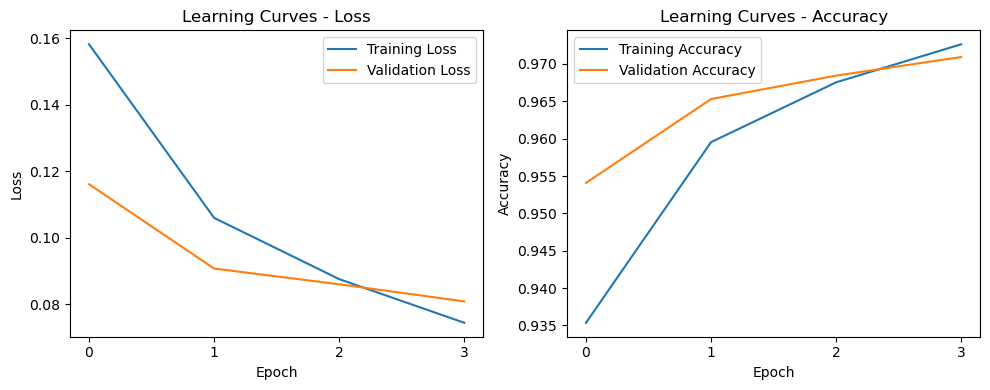

625/625 [==============================] - 76s 119ms/step


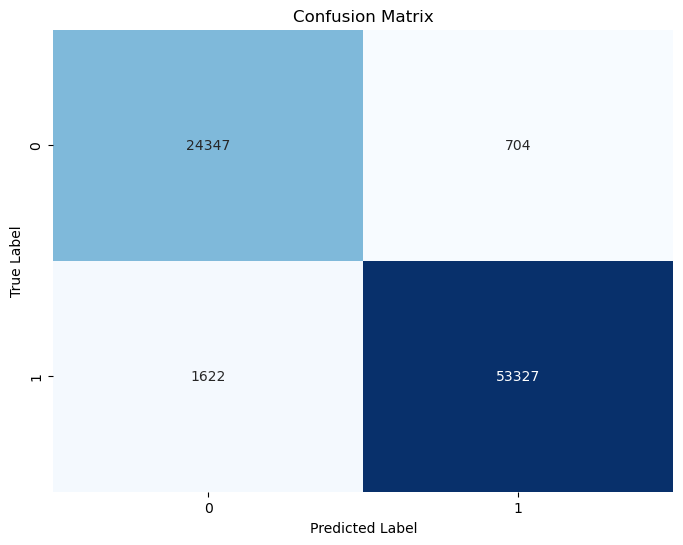

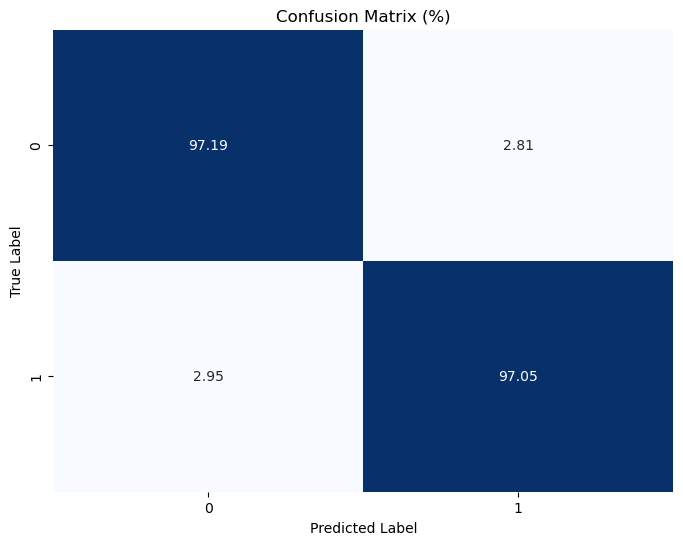

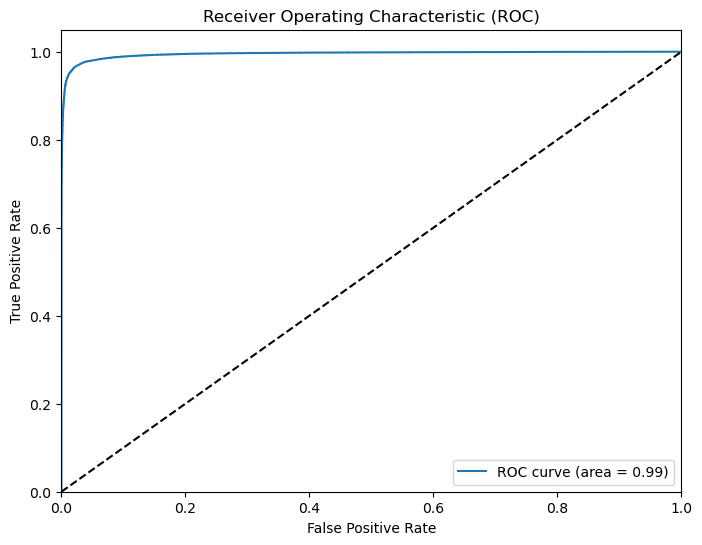

Fold 2/5
Epoch 1/4
2500/2500 [==============================] - 924s 369ms/step - loss: 0.0701 - accuracy: 0.9745 - val_loss: 0.0585 - val_accuracy: 0.9790
Epoch 2/4
2500/2500 [==============================] - 922s 368ms/step - loss: 0.0605 - accuracy: 0.9781 - val_loss: 0.0600 - val_accuracy: 0.9794
Epoch 3/4
2500/2500 [==============================] - 922s 368ms/step - loss: 0.0527 - accuracy: 0.9812 - val_loss: 0.0568 - val_accuracy: 0.9792
Epoch 4/4
2500/2500 [==============================] - 922s 368ms/step - loss: 0.0459 - accuracy: 0.9838 - val_loss: 0.0597 - val_accuracy: 0.9805


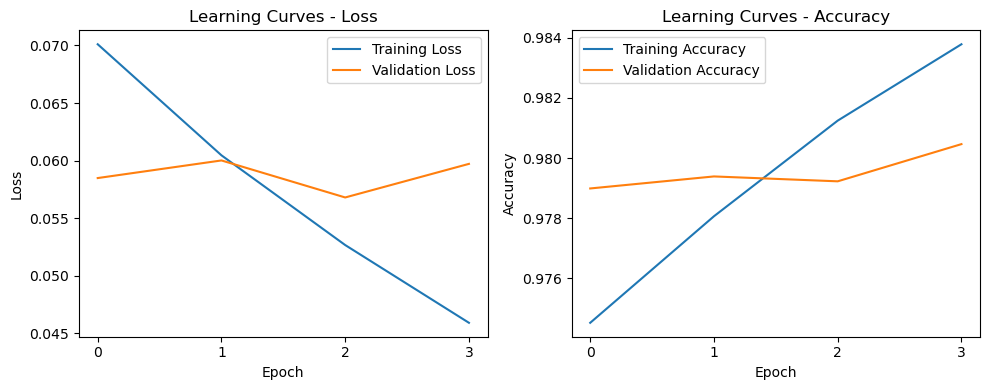

625/625 [==============================] - 74s 118ms/step


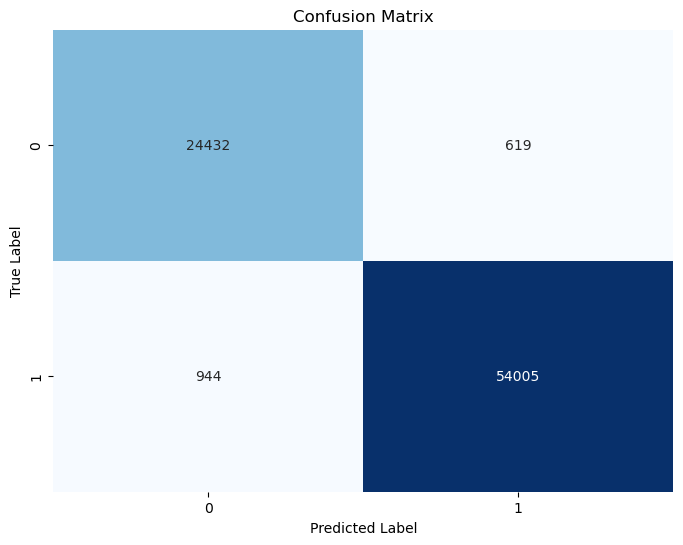

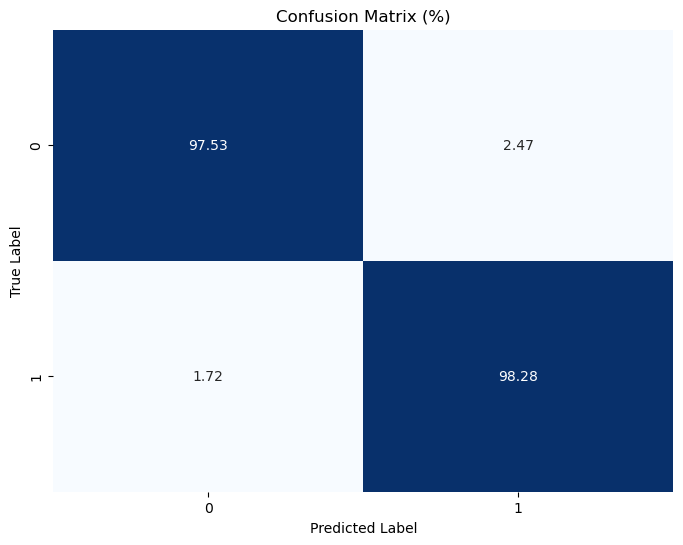

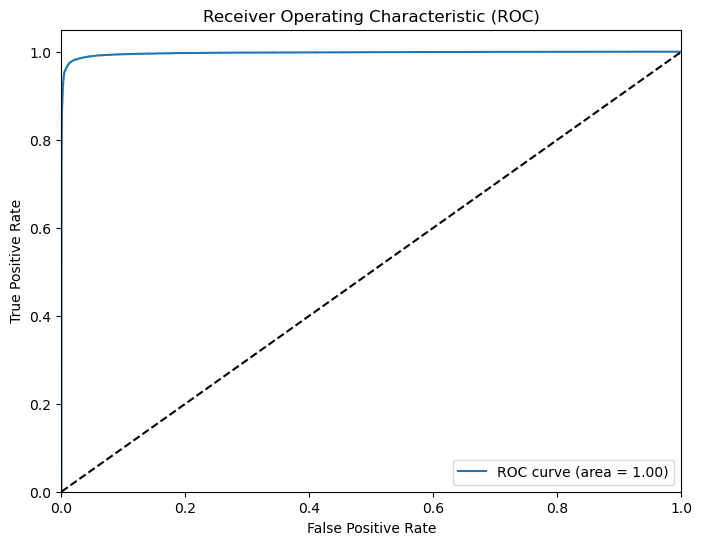

Fold 3/5
Epoch 1/4
2500/2500 [==============================] - 922s 369ms/step - loss: 0.0470 - accuracy: 0.9836 - val_loss: 0.0282 - val_accuracy: 0.9896
Epoch 2/4
2500/2500 [==============================] - 923s 369ms/step - loss: 0.0398 - accuracy: 0.9859 - val_loss: 0.0311 - val_accuracy: 0.9895
Epoch 3/4
2500/2500 [==============================] - 921s 368ms/step - loss: 0.0349 - accuracy: 0.9879 - val_loss: 0.0335 - val_accuracy: 0.9882
Epoch 4/4
2500/2500 [==============================] - 921s 368ms/step - loss: 0.0301 - accuracy: 0.9895 - val_loss: 0.0367 - val_accuracy: 0.9874


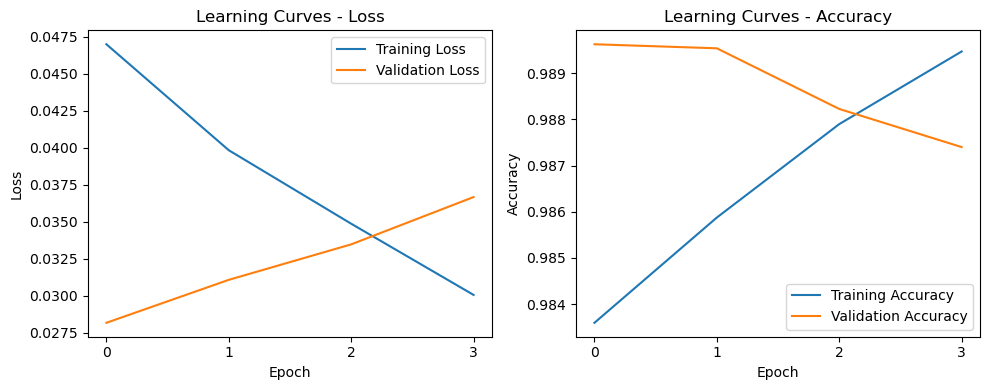

625/625 [==============================] - 74s 118ms/step


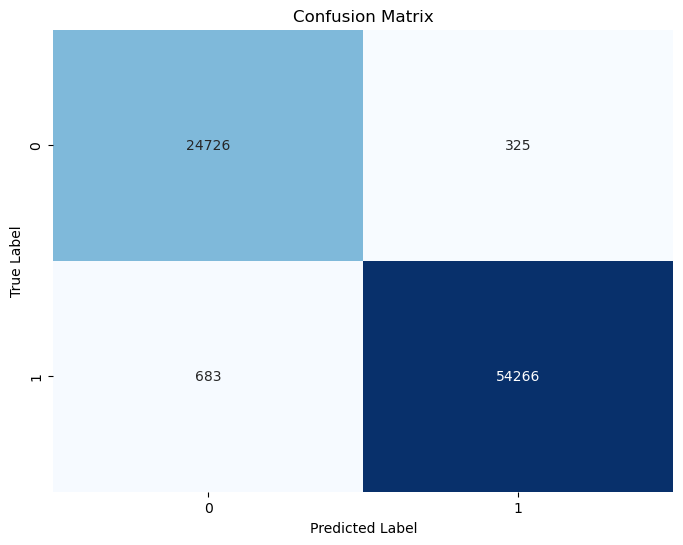

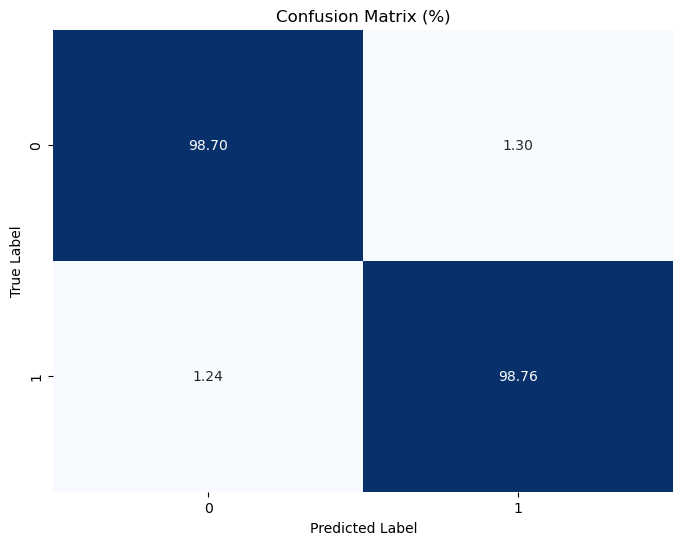

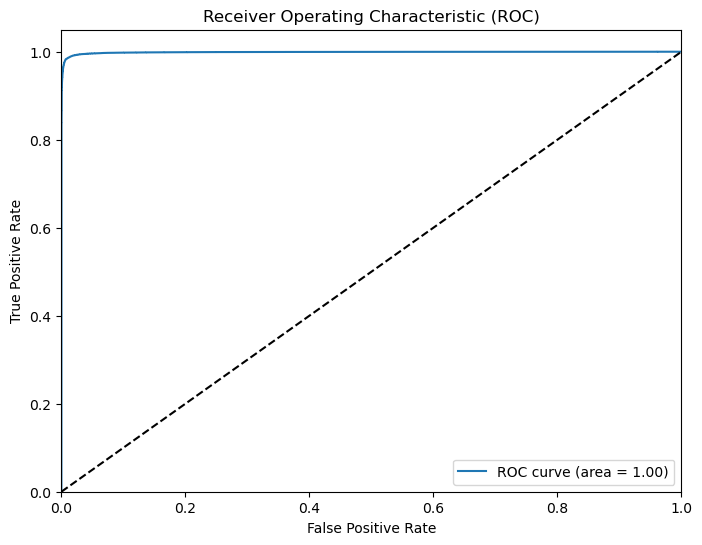

Fold 4/5
Epoch 1/4
2500/2500 [==============================] - 922s 368ms/step - loss: 0.0328 - accuracy: 0.9884 - val_loss: 0.0140 - val_accuracy: 0.9953
Epoch 2/4
2500/2500 [==============================] - 921s 368ms/step - loss: 0.0276 - accuracy: 0.9903 - val_loss: 0.0165 - val_accuracy: 0.9938
Epoch 3/4
2500/2500 [==============================] - 921s 368ms/step - loss: 0.0241 - accuracy: 0.9916 - val_loss: 0.0177 - val_accuracy: 0.9941
Epoch 4/4
2500/2500 [==============================] - 921s 368ms/step - loss: 0.0219 - accuracy: 0.9921 - val_loss: 0.0184 - val_accuracy: 0.9933


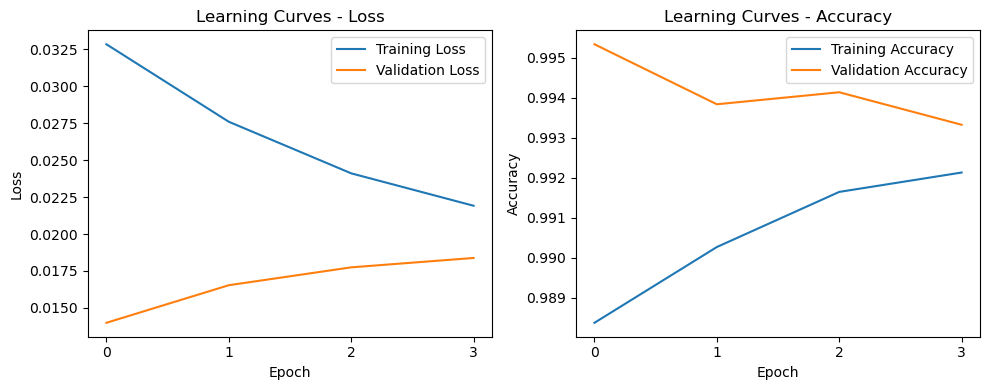

625/625 [==============================] - 74s 118ms/step


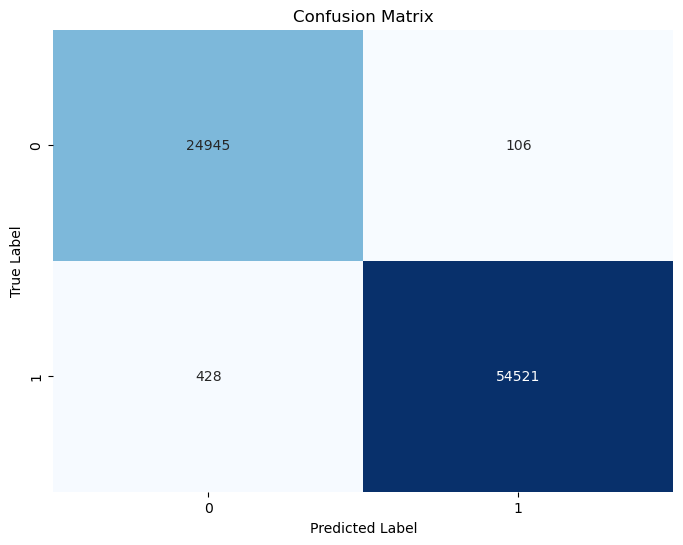

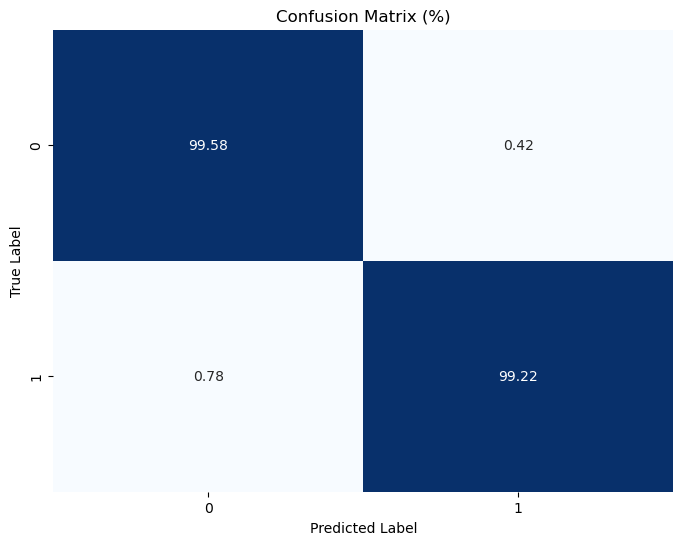

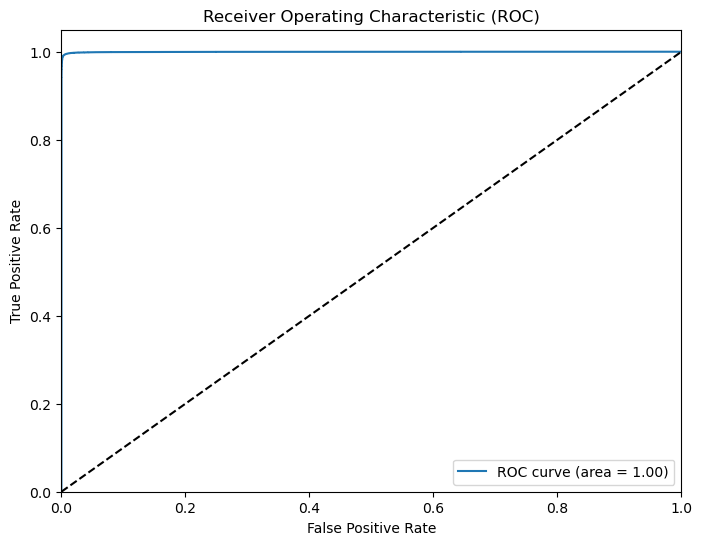

Fold 5/5
Epoch 1/4
2500/2500 [==============================] - 920s 368ms/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.0091 - val_accuracy: 0.9968
Epoch 2/4
2500/2500 [==============================] - 920s 367ms/step - loss: 0.0193 - accuracy: 0.9932 - val_loss: 0.0101 - val_accuracy: 0.9964
Epoch 3/4
2500/2500 [==============================] - 920s 367ms/step - loss: 0.0170 - accuracy: 0.9938 - val_loss: 0.0112 - val_accuracy: 0.9961
Epoch 4/4
2500/2500 [==============================] - 920s 367ms/step - loss: 0.0152 - accuracy: 0.9946 - val_loss: 0.0138 - val_accuracy: 0.9953


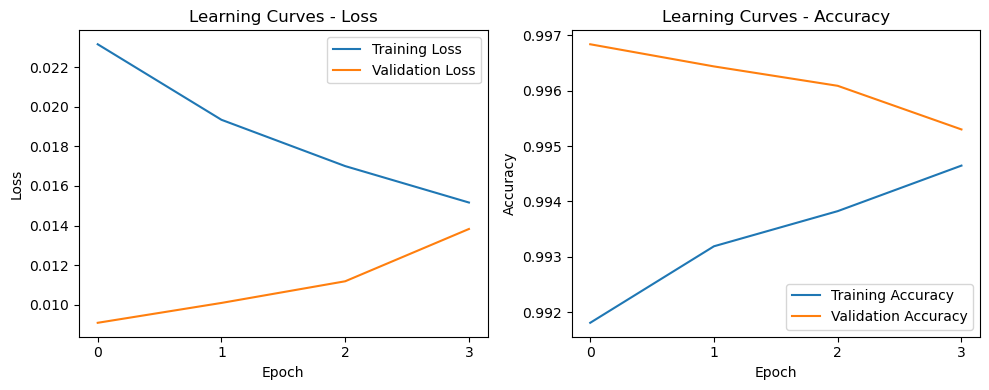

625/625 [==============================] - 74s 118ms/step


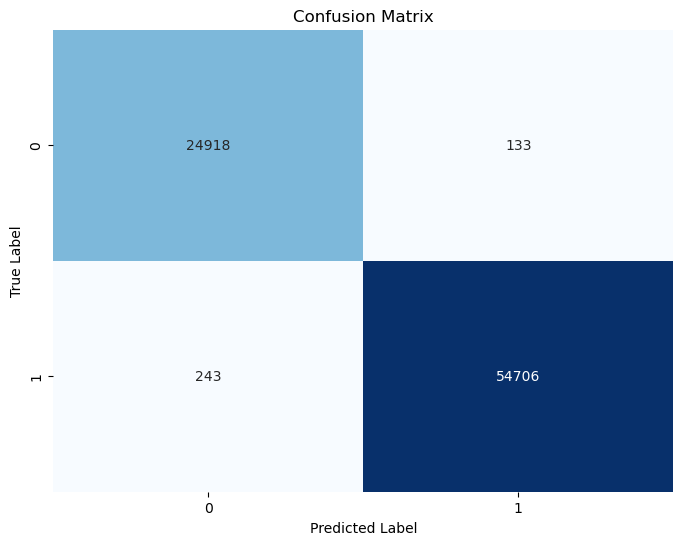

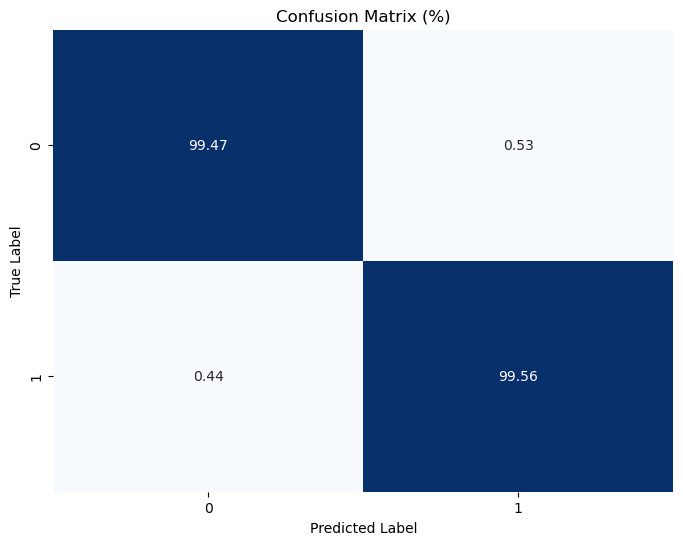

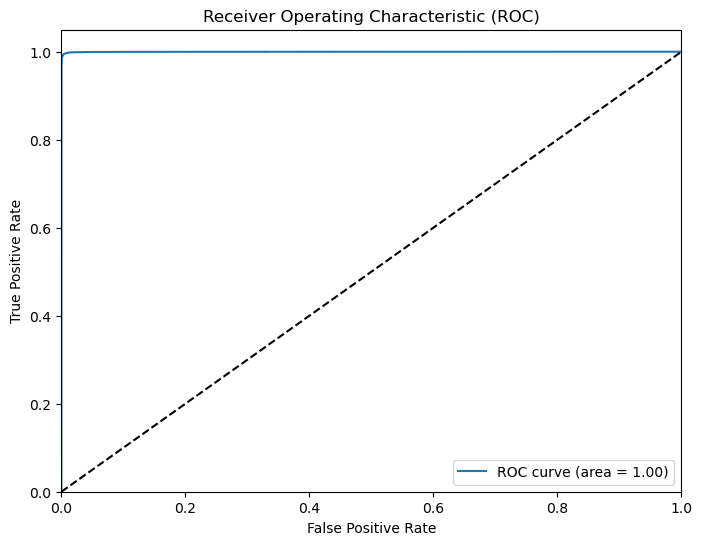

In [10]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
model.layers[-1].activation = tf.keras.activations.sigmoid  # Add sigmoid activation to the output layer
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=46)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

for fold, (train_index, test_index) in enumerate(kfold.split(input_data, labels)):
    print(f"Fold {fold + 1}/{N_FOLDS}")

    # Split the data into train and validation sets for this fold
    input_train_fold, input_test_fold = input_data[train_index], input_data[test_index]
    input_ids_train_fold, attention_masks_train_fold, labels_train_fold = zip(*input_train_fold)
    input_ids_test_fold, attention_masks_test_fold, labels_test_fold = zip(*input_test_fold)

    # Convert the input data and labels to numpy arrays
    input_ids_train_fold = np.array(input_ids_train_fold)
    attention_masks_train_fold = np.array(attention_masks_train_fold)
    labels_train_fold = np.array(labels_train_fold)
    
    input_ids_test_fold = np.array(input_ids_test_fold)
    attention_masks_test_fold = np.array(attention_masks_test_fold)
    labels_test_fold = np.array(labels_test_fold)
    
    train_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_train_fold, attention_masks_train_fold))
    train_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_train_fold)
    train_dataset_fold = tf.data.Dataset.zip((train_input_dataset_fold, train_label_dataset_fold))

    test_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_test_fold, attention_masks_test_fold))
    test_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_test_fold)
    test_dataset_fold = tf.data.Dataset.zip((test_input_dataset_fold, test_label_dataset_fold))

    # Shuffle the training dataset
    train_dataset_fold = train_dataset_fold.shuffle(buffer_size=len(input_ids_train_fold))

    # Batch and prefetch the datasets separately
    train_dataset_fold = train_dataset_fold.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset_fold = test_dataset_fold.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    history = model.fit(train_dataset_fold, validation_data=test_dataset_fold, epochs=N_EPOCHS)
    
    # Plot learning curves for this fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves - Loss')
    plt.xticks(range(0, N_EPOCHS))
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves - Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.xticks(range(0, N_EPOCHS))
    plt.show()
    
    training_accuracies.append(history.history['accuracy'])
    training_losses.append(history.history['loss'])
    val_accuracies.append(history.history['val_accuracy'])
    val_losses.append(history.history['val_loss'])
    
    (roc_auc_fold, f1_val, recall_val, accuracy_val, precision_val) = predict_and_measure_performance(model, test_dataset_fold, labels_test_fold)
    
    roc_auc_values.append(roc_auc_fold)
    f1_scores_list.append(f1_val)
    recall_scores_list.append(recall_val)
    accuracy_scores_list.append(accuracy_val)
    precision_scores_list.append(precision_val)

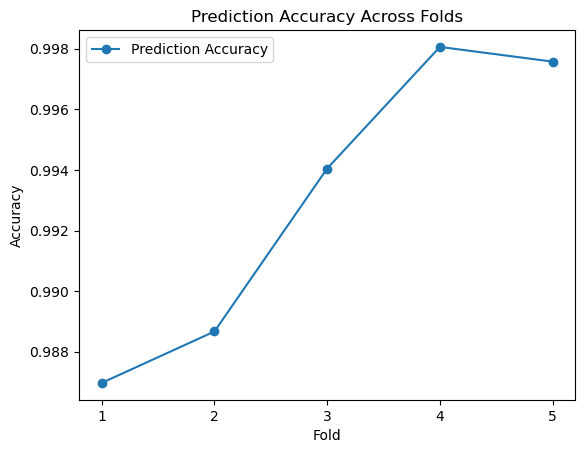

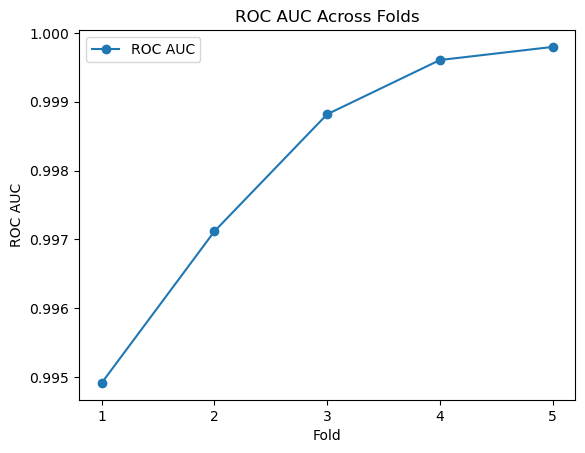

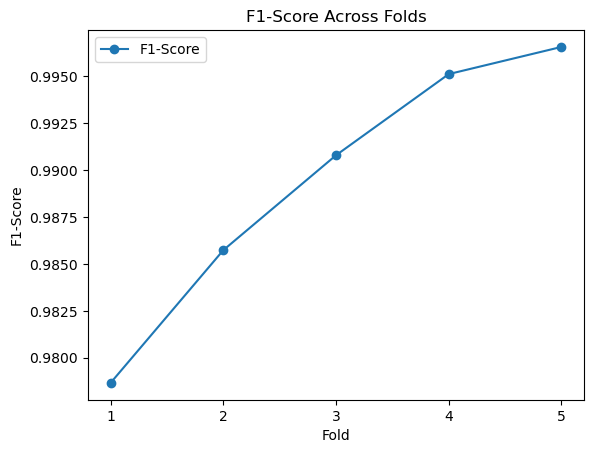

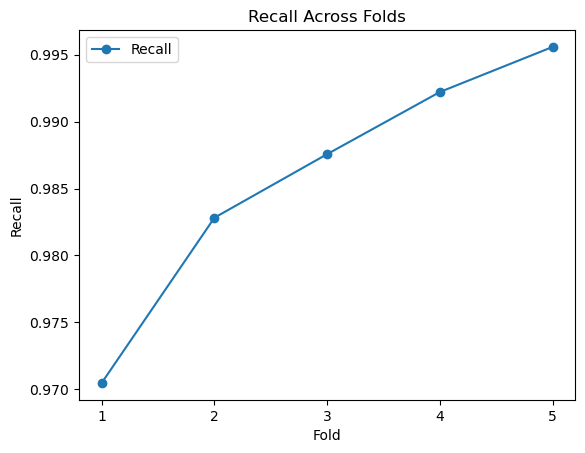

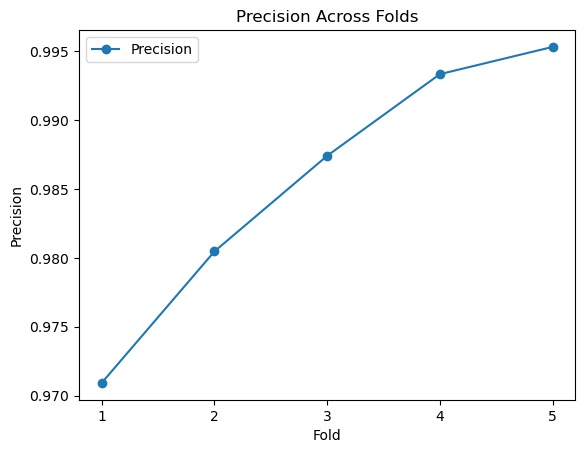

In [11]:
# Plot validation accuracy across folds
plt.plot(accuracy_scores_list, marker='o', label='Prediction Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy Across Folds')
plt.legend()
num = len(accuracy_scores_list)
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot ROC AUC across folds
plt.plot(roc_auc_values, marker='o', label='ROC AUC')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot F1-score across folds
plt.plot(f1_scores_list, marker='o', label='F1-Score')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('F1-Score Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot recall across folds
plt.plot(recall_scores_list, marker='o', label='Recall')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.title('Recall Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

# Plot precision across folds
plt.plot(precision_scores_list, marker='o', label='Precision')
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.title('Precision Across Folds')
plt.legend()
plt.xticks(range(0, num), [str(i+1) for i in range(num)])
plt.show()

In [12]:
(avg_roc, avg_f1, avg_recall, avg_accuracy, avg_precision) = calculate_average(roc_auc_values, f1_scores_list, recall_scores_list, accuracy_scores_list, precision_scores_list, N_FOLDS)
print(f"Average ROC AUC: {avg_roc}")
print(f"Average F1 Score: {avg_f1}")
print(f"Average Recall Score: {avg_recall}")
print(f"Average Accuracy Score: {avg_accuracy}")
print(f"Average Precision Score: {avg_precision}")

Average ROC AUC: 0.9980506737447076
Average F1 Score: 0.9893783882204573
Average Recall Score: 0.985732224426286
Average Accuracy Score: 0.9930638703443646
Average Precision Score: 0.9854825


In [13]:
import os
# Path to the CSV file
csv_file_path = '/kaggle/working/avg_parameter_metrics_results_400k_max.csv'

# Check if the CSV file exists
if os.path.exists(csv_file_path):
    # Load the existing CSV file into a DataFrame
    existing_df = pd.read_csv(csv_file_path)
else:
    # Create a new DataFrame if the CSV file doesn't exist
    existing_df = pd.DataFrame()

# Create a new row with the metrics data
new_row = {'Accuracy': avg_accuracy, 'ROC AUC': avg_roc, 'F1': avg_f1, 'Recall': avg_recall, 'Precision': avg_precision}

# Append the new row to the existing DataFrame
existing_df = existing_df.append(new_row, ignore_index=True)

# Save the updated DataFrame back to the CSV file
existing_df.to_csv(csv_file_path, index=False)

/tmp/ipykernel_29/658906437.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  existing_df = existing_df.append(new_row, ignore_index=True)


In [14]:
import os
# Path to the CSV file
csv_file_path = '/kaggle/working/parameter_metrics_results_400k_max.csv'

# Check if the CSV file exists
if os.path.exists(csv_file_path):
    # Load the existing CSV file into a DataFrame
    existing_df = pd.read_csv(csv_file_path)
else:
    # Create a new DataFrame if the CSV file doesn't exist
    existing_df = pd.DataFrame()

# Create a new row with the metrics data
new_row = {'Training Accuracy': training_accuracies, 'Training Loss': training_losses,'Accuracy': accuracy_scores_list, 'Loss': val_losses, 'ROC AUC': roc_auc_values, 'F1': f1_scores_list, 'Recall': recall_scores_list, 'Precision': precision_scores_list}

# Append the new row to the existing DataFrame
existing_df = existing_df.append(new_row, ignore_index=True)

# Save the updated DataFrame back to the CSV file
existing_df.to_csv(csv_file_path, index=False)

/tmp/ipykernel_29/2146599026.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  existing_df = existing_df.append(new_row, ignore_index=True)


In [18]:
# Define the input string
input_string = "Oxford LA1 5EB White Mary Jane"

# Tokenize and preprocess the input string
input_tokens = tokenizer(input_string, truncation=True, padding='max_length', max_length=50, return_tensors="tf")
input_ids = input_tokens["input_ids"]
attention_mask = input_tokens["attention_mask"]

# Make a prediction
predictions = model.predict([input_ids, attention_mask])

# Extract the predicted probability score
predicted_prob = predictions[0][0][0]

# Print the result
if predicted_prob >= 0.5:
    print(f"The input string '{input_string}' contain an address.")
else:
    print(f"The input string '{input_string}' DOES NOT contain an address.")

1/1 [==============================] - 0s 31ms/step
The input string 'Oxford LA1 5EB White Mary Jane' contain an address.


In [ ]:
print(predicted_prob)

In [ ]:
print(input_ids)

In [ ]:
print(input_tokens)

In [ ]:
print(attention_mask)

In [ ]:

subtokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(subtokens)

In [ ]:
# Define the input string
input_string = "Carl KY12 Whalley"

# Tokenize the input string
tokens = tokenizer(input_string, truncation=True, padding=True, add_special_tokens=True)

# Convert tokens into the required format
input_ids = tf.convert_to_tensor(tokens['input_ids'])[tf.newaxis, :]
attention_mask = tf.convert_to_tensor(tokens['attention_mask'])[tf.newaxis, :]

# Use the model to make predictions
output = model(input_ids, attention_mask=attention_mask)
logits = output.logits  # Extract the logits from the output

# Apply sigmoid activation to the logits to get probabilities
probabilities = tf.math.sigmoid(logits)

# Determine if it contains an address based on the threshold (e.g., 0.5)
threshold = 0.5
contains_address = probabilities >= threshold

if contains_address:
    print("The input string contains an address.")
else:
    print("The input string does not contain an address.")

In [ ]:
def custom_tokenizer(text):
    tokens = text.split(', ')
    return tokens

# Example input data
input_text = 'treadwell, BS26, 2FH'

# Tokenize the input text using the custom tokenizer
input_tokens = custom_tokenizer(input_text)

In [ ]:
# def create_tensor_dataset(input_ids, attention_mask, train_labels, BATCH_SIZE):
#     new_labels = train_labels.numpy().tolist()

#     new_features_input = {'input_ids': input_ids, 'attention_mask': attention_mask}

#     new_dataset_tensor = tf.data.Dataset.from_tensor_slices((new_features_input, new_labels))
#     new_dataset = new_dataset_tensor.batch(BATCH_SIZE).map(convert_ragged_to_dense)

#     return new_dataset


In [ ]:
# def convert_ragged_tensor(inputs, labels):
#     inputs = {'input_ids': inputs['input_ids'].to_tensor(),'attention_mask': inputs['attention_mask'].to_tensor()}
#     return inputs, labels

# def convert_ragged_to_dense(inputs, labels):
#     inputs = {'input_ids': tf.convert_to_tensor(inputs['input_ids']),'attention_mask': tf.convert_to_tensor(inputs['attention_mask'])}
#     return inputs, labels

In [ ]:
# def predict_and_measure_performance(model, val_dataset, labels_val):
#     # Perform prediction on the validation dataset
#     predictions = model.predict(val_dataset)
#     predicted_probs = predictions[0][:, 0]  # Use the first output and raw logits directly
#     predicted_labels = (predicted_probs >= 0.5).astype(int)  # Convert probabilities to binary labels

#     roc_auc = roc_auc_score(labels_val, predicted_probs)
#     f1 = f1_score(labels_val, predicted_labels)
#     recall = recall_score(labels_val, predicted_labels)
#     precision = precision_score(labels_val, predicted_labels)
#     pred_accuracy = accuracy_score(labels_val, predicted_labels)

#     # Create a confusion matrix
#     confusion_matrix_data = tf.math.confusion_matrix(labels_val, predicted_labels)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix')
#     plt.show()

#     # Calculate row sums (true label counts) and column sums (predicted label counts)
#     row_sums = confusion_matrix_data.numpy().sum(axis=1)
#     col_sums = confusion_matrix_data.numpy().sum(axis=0)
#     confusion_matrix_percentages = (confusion_matrix_data / row_sums[:, np.newaxis]) * 100
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(confusion_matrix_percentages, annot=True, fmt='.2f', cmap='Blues', cbar=False)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix (%)')
#     plt.show()

    
#     # Create and display ROC AUC plot
#     fpr, tpr, _ = roc_curve(labels_val, predicted_probs)
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC)')
#     plt.legend(loc='lower right')
#     plt.show()
    
#     return roc_auc, f1, recall, precision, pred_accuracy

In [ ]:
# def train_model(model, train_dataset, test_dataset, LEARNING_RATE, N_EPOCHS):
#     optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#     loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
#     model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    
#     model.fit(train_dataset, epochs=N_EPOCHS, verbose=1)
#     #model.evaluate(test_dataset, verbose=1)

In [ ]:
# def predict_and_calculate_metrics(model, x_test_tensor, y_test):
#     y_pred = tf.argmax(model.predict(x_test_tensor).logits, axis=1)
    
#     f1_scores_val = f1_score(y_test, y_pred, average='weighted')
#     recall_scores_val = recall_score(y_test, y_pred, average='weighted')
#     accuracy_scores_val = accuracy_score(y_test, y_pred)
#     precision_scores_val = precision_score(y_test, y_pred, average='weighted')
#     roc_auc = roc_auc_score(y_test, y_pred)
    
#     confusion_matrix_data = tf.math.confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix')
#     plt.show()
    
#     row_sums = confusion_matrix_data.numpy().sum(axis=1)
#     col_sums = confusion_matrix_data.numpy().sum(axis=0)
#     confusion_matrix_percentages = (confusion_matrix_data / row_sums[:, np.newaxis]) * 100
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(confusion_matrix_percentages, annot=True, fmt='.2f', cmap='Blues', cbar=False)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix (%)')
#     plt.show()

# #     cm = metrics.confusion_matrix(y_test, y_pred)
# #     cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test),)
# #     cm_display.plot()
# #     plt.title('Confusion Matrix')
# #     plt.show()

#     fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#     auc_score = auc(fpr, tpr)
#     plt.figure()
#     plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc_score))
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc='lower right')
#     plt.show()
    
#     return roc_auc, f1_scores_val, recall_scores_val, accuracy_scores_val, precision_scores_val



In [ ]:
# print(test_dataset.element_spec)

In [ ]:
# BATCH_SIZE = 128
# N_FOLDS = 5
# N_EPOCHS = 4
# LEARNING_RATE = 2e-5

# labels = data['Class'].tolist()

# MODEL_NAME =  'distilbert-base-uncased'
# tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
# encodings = {'input_ids': [], 'attention_mask': []}

# for entity_address_row in data['Entity_Address']:
#     entity_address_str = ' '.join(entity_address_row)
#     tokens = tokenizer(entity_address_str, truncation=True, padding=True, add_special_tokens=True)
#     encodings['input_ids'].append(tokens['input_ids'])
#     encodings['attention_mask'].append(tokens['attention_mask'])

In [ ]:
# input_ids_ragged = tf.ragged.constant(encodings['input_ids'])
# attention_masks_ragged = tf.ragged.constant(encodings['attention_mask'])
# inputs = {'input_ids': input_ids_ragged, 'attention_mask': attention_masks_ragged}

# input_ids = input_ids_ragged.to_tensor(default_value=0, shape=[None, None])
# attention_masks = attention_masks_ragged.to_tensor(default_value=0, shape=[None, None])

In [ ]:
# training_accuracies = []
# training_losses = []
# val_accuracies = []
# val_losses = []
# roc_auc_values = []
# f1_scores_list = []
# recall_scores_list = []
# accuracy_scores_list = []
# precision_scores_list = []

# model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
# kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# for train_index, test_index in kfold.split(input_ids, labels):
#     train_input_ids, test_input_ids = tf.gather(input_ids, train_index), tf.gather(input_ids, test_index)
#     train_attention_mask, test_attention_mask = tf.gather(attention_masks, train_index), tf.gather(attention_masks, test_index)
#     train_labels, test_labels = tf.gather(labels, train_index), tf.gather(labels, test_index)
    
#     train_dataset = create_tensor_dataset(train_input_ids, train_attention_mask, train_labels, BATCH_SIZE)
#     test_dataset = create_tensor_dataset(test_input_ids, test_attention_mask, test_labels, BATCH_SIZE)

#     history = model.fit(train_dataset, validation_data=test_dataset, epochs=N_EPOCHS, verbose=1)
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Learning Curves - Loss')
#     plt.xticks(range(0, N_EPOCHS))
#     plt.legend()

#     # Plot training accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['accuracy'], label='Training Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Learning Curves - Accuracy')
#     plt.legend()
#     plt.tight_layout()
#     plt.xticks(range(0, N_EPOCHS))
#     plt.show()
    
#     training_accuracies.append(history.history['accuracy'])
#     training_losses.append(history.history['loss'])
#     val_accuracies.append(history.history['val_accuracy'])
#     val_losses.append(history.history['val_loss'])
    
#     (roc_auc_fold, f1_val, recall_val, accuracy_val, precision_val) = predict_and_calculate_metrics(model, test_dataset, test_labels)
    
#     roc_auc_values.append(roc_auc_fold)
#     f1_scores_list.append(f1_val)
#     recall_scores_list.append(recall_val)
#     accuracy_scores_list.append(accuracy_val)
#     precision_scores_list.append(precision_val)

In [ ]:
# roc_auc_values.append(roc_auc_fold)
#     f1_scores_list.append(f1_val)
#     recall_scores_list.append(recall_val)
#     accuracy_scores_list.append(accuracy_val)
#     precision_scores_list.append(precision_val)

In [ ]:
# # Initialize a list to store validation accuracies for each fold
# training_accuracies = []
# training_losses = []
# val_accuracies = []
# val_losses = []
# roc_auc_values = []
# f1_values = []
# recall_values = []
# precision_values = []
# pred_accuracies = []

# model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
# kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)
# # Define the loss function and optimizer
# loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
# model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# for train_index, test_index in kfold.split(input_ids, labels):
#     train_input_ids, test_input_ids = tf.gather(input_ids, train_index), tf.gather(input_ids, test_index)
#     train_attention_mask, test_attention_mask = tf.gather(attention_masks, train_index), tf.gather(attention_masks, test_index)
#     train_labels, test_labels = tf.gather(labels, train_index), tf.gather(labels, test_index)
    
#     train_dataset = create_tensor_dataset(train_input_ids, train_attention_mask, train_labels, BATCH_SIZE)
#     test_dataset = create_tensor_dataset(test_input_ids, test_attention_mask, test_labels, BATCH_SIZE)

#     #train_model(model, train_dataset, test_dataset, LEARNING_RATE, N_EPOCHS)
#     # Train the model for this fold
#     history = model.fit(train_dataset, epochs=N_EPOCHS, verbose=1)

#     # Plot learning curves for this fold
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Learning Curves - Loss')
#     plt.xticks(range(0, N_EPOCHS))
#     plt.legend()

#     # Plot training accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['accuracy'], label='Training Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Learning Curves - Accuracy')
#     plt.legend()
#     plt.tight_layout()
#     plt.xticks(range(0, N_EPOCHS))
#     plt.show()
    
#     training_accuracies.append(history.history['accuracy'])
#     training_losses.append(history.history['loss'])
#     val_accuracies.append(history.history['val_accuracy'])
#     val_losses.append(history.history['val_loss'])
#     (roc_auc_fold, f1_fold, recall_fold, precision_fold, pred_accuracy_fold) = predict_and_measure_performance(model, test_dataset, test_labels)
    
#     f1_scores_list.append(f1_val)
#     recall_scores_list.append(recall_val)
#     accuracy_scores_list.append(accuracy_val)
#     precision_scores_list.append(precision_val)

In [ ]:
# def create_tensor_dataset(input_ids, attention_mask, train_labels, BATCH_SIZE):
#     encodings_data = {'input_ids': input_ids, 'attention_mask': attention_mask}
    
#     input_ids_ragged_data = tf.ragged.constant(encodings_data['input_ids'])
#     attention_masks_ragged_data = tf.ragged.constant(encodings_data['attention_mask'])
    
#     new_labels = train_labels.tolist()
    
#     new_features_input = {'input_ids': input_ids_ragged_data,'attention_mask': attention_masks_ragged_data}
    
#     new_dataset_tensor = tf.data.Dataset.from_tensor_slices((new_features_input, new_labels))
#     new_dataset = new_dataset_tensor.batch(BATCH_SIZE).map(convert_ragged_tensor)
    
#     return new_dataset


In [ ]:
# def create_tensor_dataset(input_ids, attention_mask, train_labels, BATCH_SIZE):
#     encodings_data = {'input_ids': [], 'attention_mask': []}
#     new_labels = train_labels
    
#     for new_data_ii in input_ids:
#         encodings_data['input_ids'].append(new_data_ii.numpy())
#     for new_data_am in attention_mask:
#         encodings_data['attention_mask'].append(new_data_am.numpy())

#     input_ids_ragged_data = tf.ragged.constant(encodings_data['input_ids'])
#     attention_masks_ragged_data = tf.ragged.constant(encodings_data['attention_mask'])
#     new_labels = new_labels.tolist()
    
#     new_features_input = {'input_ids': input_ids_ragged_data, 'attention_mask': attention_masks_ragged_data }
#     new_dataset_tensor = tf.data.Dataset.from_tensor_slices((new_features_input, new_labels))
    
#     new_dataset_batched = new_dataset_tensor.batch(BATCH_SIZE)
#     new_dataset = new_dataset_batched.map(convert_ragged_tensor)
    
#     return new_dataset


In [ ]:
# features_array = np.array([sample[0] for sample in tf_dataset])
# labels_array = np.array([sample[1] for sample in tf_dataset])

# input_ids = np.array([sample['input_ids'] for sample in features_array], dtype=object)
# attention_mask = np.array([sample['attention_mask'] for sample in features_array], dtype=object)

# for train_index, test_index in kfold.split(features_array, labels_array):
#     train_input_ids, test_input_ids = input_ids[train_index], input_ids[test_index]
#     train_attention_mask, test_attention_mask = attention_mask[train_index], attention_mask[test_index]
#     train_labels, test_labels = labels_array[train_index], labels_array[test_index]
    
#     train_dataset = create_tensor_dataset(train_input_ids, train_attention_mask, train_labels, BATCH_SIZE)
#     test_dataset = create_tensor_dataset(test_input_ids, test_attention_mask, test_labels, BATCH_SIZE)

#     train_model(model, train_dataset, test_dataset, LEARNING_RATE, N_EPOCHS)
#     (f1_val, recall_val, accuracy_val, precision_val) = predict_and_calculate_metrics(model, test_dataset, test_labels)
    
#     f1_scores_list.append(f1_val)
#     recall_scores_list.append(recall_val)
#     accuracy_scores_list.append(accuracy_val)
#     precision_scores_list.append(precision_val)

In [ ]:
#model.save('./model/clf')